In [26]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

import json

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.font_manager as font_manager

## Load in Jarren Duran's Statcast page for every at bat

In [2]:
url = "https://baseballsavant.mlb.com/savant-player/jarren-duran-680776?stats=gamelogs-r-hitting-statcast&season=2024"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
html_content = response.text

#### Scrape in order to just find the data about every individual plate appearance

In [3]:
script_tags = soup.find_all('script', type='text/javascript')

for script in script_tags:
    if 'statcastGameLogs' in script.text:
        script_content = script.text
        break
start_idx = script_content.find('statcastGameLogs: [')
start_bracket = script_content.find('[', start_idx)
end_bracket = script_content.find(']', start_bracket)

statcast_json = script_content[start_bracket:end_bracket + 1]

#### Load into Json and dataframe

In [4]:
data = json.loads(statcast_json)
df = pd.DataFrame(data)

In [5]:
df.columns

Index(['game_pk', 'play_id', 'name', 'gd', 'ab_num', 'event', 'bat_team_id',
       'fld_team_id', 'ev', 'la', 'dist', 'pull', 'brl', 'xban', 'xbad', 'hh',
       'bip', 'v', 'pt', 'pn', 'ab', 'hit', 'is_1b', 'is_2b', 'is_3b', 'is_hr',
       'so', 'bb', 'video'],
      dtype='object')

# Format dataframe into format that will be best for visualization
#### Drop all unnecessary columns

In [6]:
df = df.drop(['video', 'bat_team_id', 'game_pk', 'play_id', 'xbad'], axis=1)

#### Make sure it is only balls in play, so we can visualize all batted balls

In [7]:
df_bip = df[df['bip'] == '1']
df_bip
df_bip['ab'].unique()

array(['1', '0'], dtype=object)

#### Typecast all of the data into the correct format

In [8]:
df_bip = df_bip.copy()
df_bip.loc[:, 'gd'] = pd.to_datetime(df_bip['gd'])
float_data = ['ev', 'la', 'xban', 'v']
int_data = ['ab_num', 'dist', 'brl', 'hh', 'bip', 'ab', 'hit', 'is_1b', 'is_2b', 'is_3b', 'is_hr', 'so', 'bb', 'fld_team_id']
for col in float_data:
    df_bip.loc[:, col] = df_bip[col].astype(float)
for col in int_data:
    df_bip.loc[:, col] = df_bip[col].astype(int)

#### Manually find the team id for all of the teams in order to map them and create a new team column

In [9]:
mlb_teams = {
    108: "Angels",
    134: "Pirates",
    114: "Guardians",
    112: "Cubs",
    137: "Giants",
    120: "Nationals",
    138: "Cardinals",
    158: "Brewers",
    144: "Braves",
    143: "Phillies",
    113: "Reds",
    135: "Padres",
    146: "Marlins",
    133: "Athletics",
    119: "Dodgers",
    115: "Rockies",
    136: "Mariners",
    118: "Royals",
    140: "Rangers",
    117: "Astros",
    109: "Diamondabcks",
    116: "Tigers",
    121: "Mets",
    145: "White Sox",
    110: "Orioles",
    147: "Yankees",
    142: "Twins",
    141: "Blue Jays",
    139: "Rays"
}

In [10]:
df_bip.loc[:, "opp_team"] = df_bip.loc[:, "fld_team_id"].map(mlb_teams)
df_bip = df_bip.drop("fld_team_id", axis=1)

#### Make a hit type column

In [11]:
# df_bip['hit_type'] = df_bip['is_1b'] + 2*df_bip['is_2b'] + 3*df_bip['is_3b'] + 4*df_bip['is_hr']
# df_bip = df_bip.drop(['hit', 'is_1b', 'is_2b', 'is_3b', 'is_hr'], axis=1)

In [34]:
print(df_bip['event'].unique())
# df_only_hits = df_bip[df_bip['hit'] == 1]

['field_out' 'single' 'double' 'triple' 'grounded_into_double_play'
 'field_error' 'home_run' 'force_out' 'sac_fly' 'fielders_choice_out'
 'sac_bunt']


### Make some general important stats

In [54]:
oppo_pct = round(sum(df_only_hits["pull"] == "Opposite") / df_only_hits.shape[0] * 100)
straight_pct = round(sum(df_only_hits["pull"] == "Straightaway") / df_only_hits.shape[0] * 100)
pull_pct = round(sum(df_only_hits["pull"] == "Pull") / df_only_hits.shape[0] * 100)

# Begin process of visualizing the data

In [17]:
img = mpimg.imread('fenway_park_outline_enhanced.jpg')
font_path = 'Beantown-vmEE.ttf'
font_props = font_manager.FontProperties(fname=font_path)

#### Function that can change the direciton and distance to match scale on graphic

In [91]:
df_only_hits['xban'].min()

0.001

In [111]:
colors_dict = {
    'home_run': "#5E35B1",
    'triple': '#e60000',
    'double': '#0041C2',
    'single': '#FFDE21'
    }

def df_to_graph(row_idx):
    
    row_vals = df_only_hits.loc[row_idx]
    direction = row_vals['pull']
    distance = row_vals['dist']
    scaled_distance = distance * 910/390
    hit_type = row_vals['event']
    xba = row_vals['xban']
    size = 100*xba**2 + 100*xba + 30
    size = ((xba - 0.001) / (1 - 0.001))**2 * (300 - 30) + 30
    if direction == "Straightaway":
        x_coord = 0
        y_coord = scaled_distance
    elif direction == "Opposite":
        x_coord = scaled_distance * np.cos(125*np.pi/180)
        y_coord = scaled_distance * np.sin(125*np.pi/180)
    elif direction == "Pull":
        x_coord = scaled_distance * np.cos(55*np.pi/180)
        y_coord = scaled_distance * np.sin(55*np.pi/180)

    return x_coord, y_coord, hit_type, colors_dict[hit_type], size

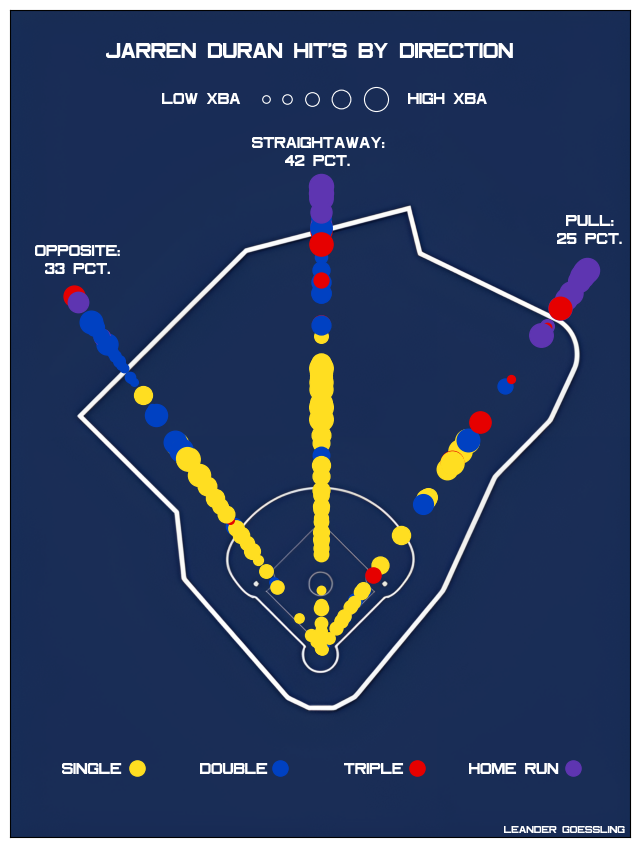

In [134]:
fig, ax = plt.subplots(figsize=(8, 12))
background_color = "#192c55"

# Display Fenway Park image
ax.imshow(img, extent=[-678, 674, -409, 1395])  # Adjust the extent to match the scale of the image

ax.set_xticks([])  # Remove x-axis ticks
ax.set_yticks([])  # Remove y-axis ticks
ax.set_xlabel('')
ax.set_ylabel('')

#Title
fig.text(0.5, 0.8, "jarren duran hit's by direction", ha='center', fontsize=16, color="white", fontproperties=font_props)

#Tendency captions
fig.text(0.21, 0.635, f"opposite:", ha='center', fontsize=12, color="white", fontproperties=font_props)
fig.text(0.21, 0.62, f"{oppo_pct} pct.", ha='center', fontsize=12, color="white", fontproperties=font_props)

fig.text(0.51, 0.725, "straightaway:", ha='center', fontsize=12, color="white", fontproperties=font_props)
fig.text(0.51, 0.71, f"{straight_pct} pct.", ha='center', fontsize=12, color="white", fontproperties=font_props)

fig.text(0.85, 0.66, "pull:", ha='center', fontsize=12, color="white", fontproperties=font_props)
fig.text(0.85, 0.645, f"{pull_pct} pct.", ha='center', fontsize=12, color="white", fontproperties=font_props)

# xBA legend

ax.text(-175, 1190, "low xba", ha='right', fontsize=12, color="white", fontproperties=font_props)

ax.scatter(x=-120, y=1200, s=30, color=background_color, edgecolor='white', linewidth=.8)
ax.scatter(x=-75, y=1200, s=46.875, color=background_color, edgecolor='white', linewidth=.8)
ax.scatter(x=-20, y=1200, s=97.5, color=background_color, edgecolor='white', linewidth=.8)
ax.scatter(x=43.5, y=1200, s=181.875, color=background_color, edgecolor='white', linewidth=.8)
ax.scatter(x=120, y=1200, s=300, color=background_color, edgecolor='white', linewidth=.8)

ax.text(190, 1190, "high xba", ha='left', fontsize=12, color="white", fontproperties=font_props)

# Hit Type Legend

ax.text(-500, -270, "single", ha='center', fontsize=12, color="white", fontproperties=font_props)
ax.scatter(x=-400, y=-259, s=120, color=colors_dict["single"])

ax.text(-190, -270, "double", ha='center', fontsize=12, color="white", fontproperties=font_props)
ax.scatter(x=-90, y=-259, s=120, color=colors_dict["double"])

ax.text(115, -270, "triple", ha='center', fontsize=12, color="white", fontproperties=font_props)
ax.scatter(x=210, y=-259, s=120, color=colors_dict["triple"])

ax.text(420, -270, "home run", ha='center', fontsize=12, color="white", fontproperties=font_props)
ax.scatter(x=550, y=-259, s=120, color=colors_dict["home_run"])


#Plotting all of the hits
for idx in df_only_hits.index:
    plot_vals = df_to_graph(idx)
    ax.scatter(plot_vals[0], plot_vals[1], color=plot_vals[3], s=plot_vals[4])

# Signature
ax.text(664, -400, "leander goessling", ha='right', fontsize=8, color="white", fontproperties=font_props)


plt.savefig('jarren_duran_1.png', bbox_inches='tight')
plt.show()